In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import plotly.express as px
import missingno as msno
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# import bigjson
import json
from collections import defaultdict
from igraph import *
import igraph as ig
from cairo import *
import math
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cairo'

In [3]:
!pip install cairo

ERROR: Could not find a version that satisfies the requirement cairo (from versions: none)
ERROR: No matching distribution found for cairo


In [5]:
all_keys = set()
count = 0
with open('/kaggle/input/cndbv13/test1.json', 'rb') as fin:
    for _ in range(100000):
        count += 1
        all_keys.update(json.loads(next(fin)))
print(sorted(all_keys))

['_id', 'abstract', 'authors', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references', 'title', 'url', 'venue', 'volume', 'year']


In [6]:
references_dict = defaultdict(list)

for path in [
    '/kaggle/input/cndbv13/test1.json',
    '/kaggle/input/cndbv13/test2.json',
    '/kaggle/input/cndbv13/test3.json',
    '/kaggle/input/cndbv13/test4.json',
    '/kaggle/input/cndbv13/test5.json'
]:
    with open(path, 'rb') as fin:
        cur_num = 0
        max_num = 10000
        line = next(fin)
        
        try:
            while line:
                cur_num += 1
                if cur_num == max_num:
                    break

                element = json.loads(line)
                line = next(fin)

                for reference in element.get('references', [np.nan]):
                    for key in ['_id', 'abstract', 'doi', 'fos', 'isbn', 'issn', 'issue', 
                                'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 
                                'references', 'title','volume', 'year']:
                        references_dict[key].append(element.get(key, np.nan))

                    references_dict['url'].append(', '.join(element.get('url', [])))

                    authors = element.get('authors')
                    if authors is not None:
                        author_ids = '; '.join([x.get('_id', '') for x in authors if x is not None])
                        author_names = '; '.join([x.get('name', '') for x in authors if x is not None])
                    else:
                        author_ids = np.nan
                        author_names = np.nan
                    references_dict['author_ids'].append(author_ids)
                    references_dict['author_names'].append(author_names)

                    venue = element.get('venue')
                    if venue is not None:
                        venue_id = element['venue'].get('_id', np.nan)
                        venue_name = element['venue'].get('raw', np.nan)
                    else:
                        venue_id = np.nan
                        venue_name = np.nan
                    references_dict['venue_id'].append(venue_id)
                    references_dict['venue_name'].append(venue_name)
        
        except StopIteration as ex:
            pass

references_dict['id'] = references_dict.pop('_id')

In [7]:
data = pd.DataFrame.from_dict(references_dict)
data.head()

,abstract,doi,fos,isbn,issn,issue,keywords,lang,n_citation,page_end,...,references,title,volume,year,url,author_ids,author_names,venue_id,venue_name,id
0,NaN,10.1145/1135777.1135863,NaN,,,,NaN,en,647.0,594,...,NaN,Semantic Wikipedia.,,2006.0,"http://doi.acm.org/10.1145/1135777.1135863, db...",53f47915dabfaefedbbb728f; 53f44a27dabfaedf435d...,Max Völkel; Markus Krötzsch; Denny Vrandecic; ...,53a7257a20f7420be8b50425,WWW,53a7258520f7420be8b514a9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Deductive Algorithmic Knowledge.,NaN,2004.0,http://rutcor.rutgers.edu/~amai/aimath04/Accep...,,Riccardo Pucella,53a725d920f7420be8b5b577,AMAI,53a725db20f7420be8b5bfc6
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Improving Exact Algorithms for MAX-2-SAT.,NaN,2004.0,http://rutcor.rutgers.edu/~amai/aimath04/Accep...,53f4469bdabfaedd74def186; 54054904dabfae450f3a...,Haiou Shen; Hantao Zhang,53a725d920f7420be8b5b577,AMAI,53a725db20f7420be8b5bff3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Learning via Finitely Many Queries.,NaN,2004.0,http://rutcor.rutgers.edu/~amai/aimath04/Accep...,,Andrew C. Lee,53a725d920f7420be8b5b577,AMAI,53a725db20f7420be8b5bffb
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A Framework for Sequential Planning in Multi-A...,NaN,2004.0,http://rutcor.rutgers.edu/~amai/aimath04/Accep...,; 5406cb05dabfae44f085c48f,Piotr J. Gmytrasiewicz; Prashant Doshi,53a725d920f7420be8b5b577,AMAI,53a725db20f7420be8b5c00f


# Data gaps

In [8]:
data.shape, data.id.unique().shape # уникальных статей чуть меньше 50к

((372597, 22), (49995,))

In [9]:
data = data.loc[data.astype(str).drop_duplicates().index] # удаляем дубликаты

In [10]:
data.shape

(49995, 22)

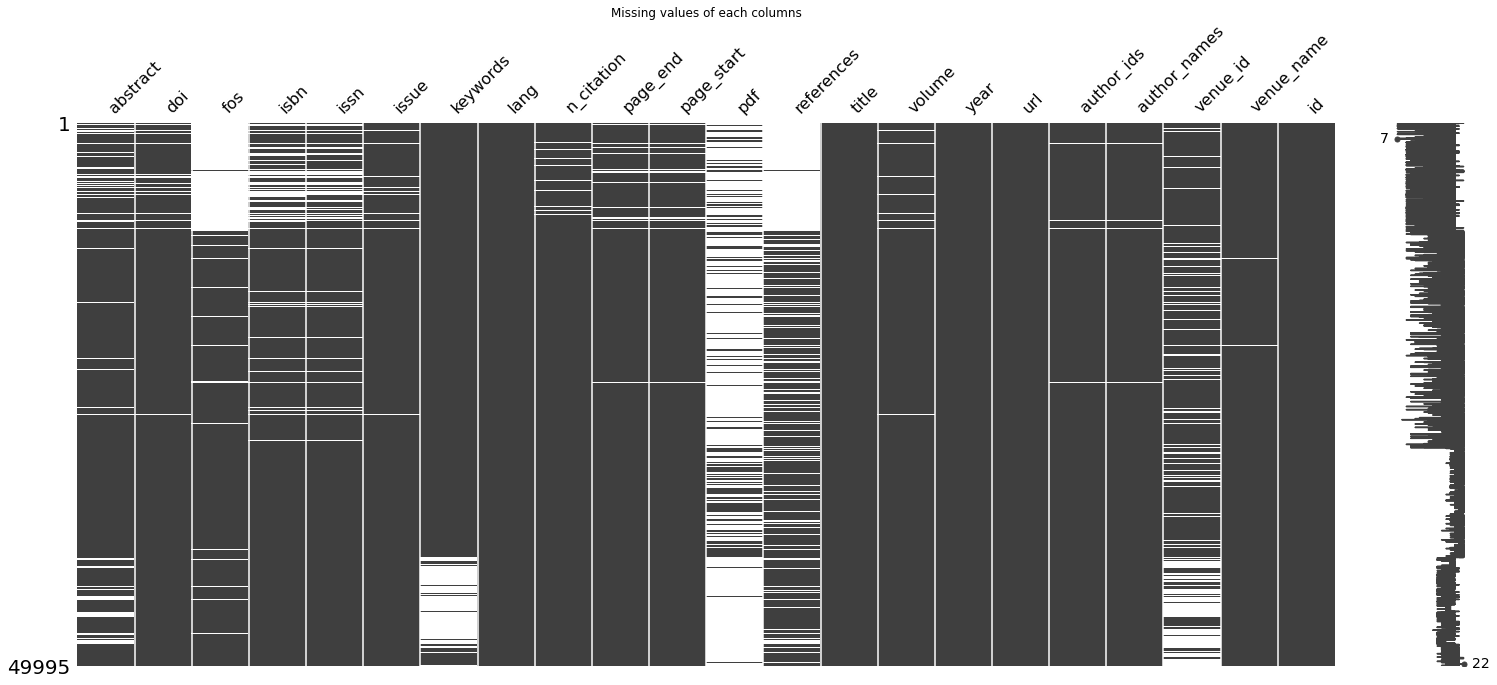

In [11]:
msno.matrix(data)
plt.title('Missing values of each columns');

# Language distribution

In [12]:
lang_data = data.lang[data.lang.notnull()]
lang_data.value_counts()

en    49958
zh        4
Name: lang, dtype: int64

In [13]:
lang_data.isnull().sum() # 0

0

In [14]:
keys, values = lang_data.value_counts().index, lang_data.value_counts().values

fig = px.bar(x=keys, y=values, color=keys,
             color_discrete_sequence=px.colors.sequential.Blues,
             title='Distribution of languages')

fig.update_layout(xaxis_title="language", yaxis_title="amount")

fig.data[0].marker.line.width = 1
fig.data[0].marker.line.color = "blue"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "crimson"

fig.show();

# Years distribution

In [15]:
years_data = data.year
years_data.value_counts().sort_values(ascending=False)

2017.0    9087
2013.0    6791
2011.0    4830
2010.0    2446
2009.0    2226
          ... 
1894.0       1
1927.0       1
1874.0       1
1929.0       1
1943.0       1
Name: year, Length: 114, dtype: int64

In [16]:
print(years_data.isnull().sum()) # 0

0


In [17]:
sorted(years_data.value_counts().index)[:10]

[0.0, 13.0, 1874.0, 1894.0, 1898.0, 1901.0, 1903.0, 1905.0, 1907.0, 1911.0]

In [18]:
print(sorted(years_data.value_counts().index)[:2]) # минимальные значения year: [0.0, 13.0]
years_data[(years_data == 0) | (years_data == 13)].shape # 8 статей с (year =  0 или 13)

[0.0, 13.0]


(8,)

In [19]:
sorted(years_data.value_counts().index)[-10:] # топ 10

[2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0]

In [20]:
years_data = years_data.drop(years_data[(years_data == 0) | (years_data == 13)].index) # удаляем строчки с (year = 0 или 13)

In [21]:
sorted(years_data.value_counts().index)[:10] # топ 10

[1874.0,
 1894.0,
 1898.0,
 1901.0,
 1903.0,
 1905.0,
 1907.0,
 1911.0,
 1912.0,
 1916.0]

In [22]:
keys = list(map(lambda x: str(int(x)), years_data.value_counts().sort_values(ascending=False).index[:10]))
values = list(years_data.value_counts().sort_values(ascending=False).values[:10])

values.append(years_data.value_counts().sort_values(ascending=False).values[10:].sum())
keys.append('other') # весего уникальных значение в year 112, виден дисбаланс

fig = px.bar(x=keys, y=values, title = 'Rank of years', text_auto='.2s', labels={'x': 'year', 'y': 'number of articles'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)

fig.show();

In [23]:
years_data.value_counts()[years_data.value_counts() == 1].shape # 13 значений по 1 статье

(13,)

# Authors

In [24]:
data.author_names

0         Max Völkel; Markus Krötzsch; Denny Vrandecic; ...
1                                          Riccardo Pucella
2                                  Haiou Shen; Hantao Zhang
3                                             Andrew C. Lee
4                    Piotr J. Gmytrasiewicz; Prashant Doshi
                                ...                        
372561    Rhys Heffernan; Yuedong Yang; Kuldip K. Paliwa...
372580    Robert Kleffner; Jeff Flatten; Andrew Leaver-F...
372584    Nikolaos K. Chlis; F. Alexander Wolf; Fabian J...
372585    Feng Zeng; Zicheng Wang; Ying Wang; Jizhong Zh...
372593    Nicolas Städler; Frank Dondelinger; Steven M. ...
Name: author_names, Length: 49995, dtype: object

In [25]:
author_names = data.author_names
author_names.isnull().sum()

635

In [26]:
author_names.fillna('', inplace=True)

In [27]:
author_names.isnull().sum()

0

In [28]:
author_names[0]

'Max Völkel; Markus Krötzsch; Denny Vrandecic; Heiko Haller; Rudi Studer'

In [29]:
list(map(lambda x: x.strip(), data.author_names[0].split(';')))

['Max Völkel',
 'Markus Krötzsch',
 'Denny Vrandecic',
 'Heiko Haller',
 'Rudi Studer']

In [30]:
def preparation_func(string):
    '''Разделяем строку по ';' и убираем пробелы по краям у каждого автора'''
    return list(map(lambda x: x.strip(), string.split(';')))

In [31]:
author_names

0         Max Völkel; Markus Krötzsch; Denny Vrandecic; ...
1                                          Riccardo Pucella
2                                  Haiou Shen; Hantao Zhang
3                                             Andrew C. Lee
4                    Piotr J. Gmytrasiewicz; Prashant Doshi
                                ...                        
372561    Rhys Heffernan; Yuedong Yang; Kuldip K. Paliwa...
372580    Robert Kleffner; Jeff Flatten; Andrew Leaver-F...
372584    Nikolaos K. Chlis; F. Alexander Wolf; Fabian J...
372585    Feng Zeng; Zicheng Wang; Ying Wang; Jizhong Zh...
372593    Nicolas Städler; Frank Dondelinger; Steven M. ...
Name: author_names, Length: 49995, dtype: object

In [32]:
author_names = author_names.apply(lambda x: preparation_func(x))

In [33]:
author_names[0]

['Max Völkel',
 'Markus Krötzsch',
 'Denny Vrandecic',
 'Heiko Haller',
 'Rudi Studer']

In [34]:
data.author_names = author_names

In [35]:
authors = defaultdict(int)
for lst in author_names.values:
    for elem in lst:
        authors[elem] += 1 

In [36]:
authors[''] = 0

In [37]:
sorted(authors.values())[-10:]

[19, 19, 20, 21, 23, 23, 26, 27, 27, 72]

In [38]:
sorted(authors.keys())[-10:]

['İsmail Dinçer',
 'İsmail Yaslan',
 'Łukasz Kiedrowski',
 'Łukasz Matuszak',
 'Łukasz Sosnowski',
 'łukasz kaczmarczyk',
 'Şakir Şimşir',
 'Şebnem Düzgün',
 'Štefko Miklavič',
 '耕一 平田']

## Имена могут быть записаны по-разному, поэтому обратимся к id авторов

In [39]:
author_ids = data.author_ids
author_ids.isnull().sum()

635

In [40]:
author_ids = author_ids.fillna('')

In [41]:
author_ids = author_ids.apply(lambda x: preparation_func(x))

In [42]:
data.author_ids = author_ids
data.author_ids.head()

0    [53f47915dabfaefedbbb728f, 53f44a27dabfaedf435...
1                                                   []
2    [53f4469bdabfaedd74def186, 54054904dabfae450f3...
3                                                   []
4                         [, 5406cb05dabfae44f085c48f]
Name: author_ids, dtype: object

In [43]:
author_ids_dict = defaultdict(int)
for lst in author_ids.values:
    for elem in lst:
        author_ids_dict[elem] += 1 

In [44]:
keys = np.array(list(author_ids_dict.keys()))
keys[np.array(list(map(lambda x: len(x), keys))) < 5] # смотрим ключи длинной меньше 5

array([''], dtype='<U24')

In [45]:
author_ids_dict.pop('')

16868

In [46]:
len(author_ids_dict.values())

103108

In [47]:
sorted(author_ids_dict.values())[-10:] # топ 10 авторов по количеству статей

[13, 14, 14, 15, 15, 16, 20, 21, 27, 72]

In [48]:
(np.array(list((author_ids_dict.values()))) == 1).sum() # почти 90к авторов с 1 статьей

89749

In [49]:
counter = defaultdict(int)
for value in author_ids_dict.values():
    counter[value] += 1

In [50]:
keys, values = list(counter.keys()), list(counter.values())

fig = px.bar(x=keys, y=values, 
             title = 'Distribution of authors by number of articles', 
             width=1600, height=800, 
             labels={'x': 'number of articles', 'y': 'number of authors'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=2, opacity=0.7)

fig.show()

In [51]:
len(author_ids_dict) # всего авторов

103108

In [52]:
keys, values = list(range(1, 11)), sorted(author_ids_dict.values())[-10:]

fig = px.bar(x=keys, y=values, title = 'Top 10 authors by number of articles', text_auto='.2s', labels={'y': 'number of articles'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=2, opacity=0.7)

fig.show()

# Venue

In [53]:
data.venue_name.unique().shape, data.venue_id.unique().shape # второе значение - это количество уникальных журналов, статей, конференций и т.д.

((7304,), (6579,))

In [54]:
venue_ids = data.venue_id

In [55]:
venue_ids.value_counts()

55f957d4c35f4fb0d21ce0f1    385
5390796b20f770854f5b916d    374
53a72b0920f7420be8c16721    270
53a732db20f7420be8dba361    241
581304169ed5dbf6f8d2c460    228
                           ... 
555037bb7cea80f954197d69      1
53a7252220f7420be8b46a96      1
5390b76320f70186a0f22a06      1
53a72df020f7420be8c78b45      1
53a72e6520f7420be8c8bddd      1
Name: venue_id, Length: 6578, dtype: int64

In [56]:
names_of_venue = []
for id_ in venue_ids.value_counts().index:
    names_of_venue.append(data.venue_name[data.venue_id == id_].values[0])

In [57]:
names_of_venue[:20]

['Decision and Control',
 'Neural Computation',
 'INFOCOM',
 'Encyclopedia of Cryptography and Security (2nd Ed.)',
 'Multimedia Tools Appl.',
 'Bell System Technical Journal, The',
 'Geoscience and Remote Sensing Symposium',
 'Commun. ACM',
 'Datenschutz und Datensicherheit',
 'Scholarpedia',
 'ISCC',
 'Encyclopedia of Parallel Computing',
 'SIGGRAPH Electronic Art and Animation Catalog',
 'IJCNN',
 'ICASSP), 2002 IEEE International Conference',
 'Neural Computing and Applications',
 'Electronics, Circuits, and Systems',
 'INFOCOM Workshops',
 'Artificial Life',
 'Image Processing']

In [58]:
counter_venues = defaultdict(int)
for value in venue_ids.value_counts().values:
    counter_venues[value] += 1

In [59]:
keys, values = list(counter_venues.keys()), list(counter_venues.values())

fig = px.histogram(x=keys, y=values, 
             title = 'Distribution of authors by number of articles', 
             width=1600, height=800, 
             labels={'x': 'number of articles', 'y': 'number of authors'}, nbins=100, text_auto='.1s')

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  opacity=0.7)

fig.show()

In [60]:
len(names_of_venue), venue_ids.value_counts().shape

(6578, (6578,))

In [61]:
keys, values = names_of_venue[:10], venue_ids.value_counts().values[:10]

fig = px.bar(x=keys, y=values, title = 'Top venues by number of articles', text_auto='.3s', 
             labels={'x': 'name of venue', 'y': 'number of articles'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)

fig.show();

# Citations

In [62]:
n_citation = data.n_citation
n_citation.isnull().sum()

724

In [63]:
n_citation.head(10)

0    647.0
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7     41.0
8      NaN
9      NaN
Name: n_citation, dtype: float64

In [64]:
n_citation = n_citation.fillna(0)
data.n_citation = n_citation

In [65]:
n_citation.sort_values(ascending=False)

232747    77820.0
9828      26477.0
2331      21999.0
9125      19860.0
3382      14570.0
           ...   
10089         0.0
10091         0.0
2487          0.0
105268        0.0
134509        0.0
Name: n_citation, Length: 49995, dtype: float64

In [66]:
citation_counter = defaultdict(int)
for indx in data.index:
    for author_id in data.author_ids[indx]:
        citation_counter[author_id] += data.n_citation[indx]
citation_counter[''] = 0

In [67]:
# sorted(list(citation_counter.items()), key=lambda x: -x[1])

In [68]:
sorted(list(citation_counter.values()), reverse=True)[:10]

[77820.0,
 26477.0,
 25215.0,
 25215.0,
 25111.0,
 19860.0,
 16449.0,
 14570.0,
 14570.0,
 13133.0]

In [69]:
keys, values = range(10), sorted(list(citation_counter.values()), reverse=True)[:10]

fig = px.bar(x=keys, y=values, 
                  title = 'Distribution of authors by number of citations', 
                  text_auto='.4s',
                  labels={'y': 'number of citations'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=2, opacity=0.7)

fig.show()

In [70]:
data.author_names[n_citation.sort_values(ascending=False).index[:10]]

232747                                  [Claude E. Shannon]
9828                                         [D. L. Donoho]
2331                                           [W S BRINES]
9125                                          [Leo Breiman]
3382                       [C. de L. Ryals, K. J. Fielding]
7373                                          [John Cullen]
117794    [Garrett M. Morris, David S. Goodsell, Robert ...
240071      [Sch&#246, lkopf, B, Smola, A, M&#252, ller, K]
559       [Dennis A. Benson, Mark S. Boguski, David J. L...
230362                                [Foschini, Gerard J.]
Name: author_names, dtype: object

In [71]:
keys, values = range(10), n_citation.sort_values(ascending=False).values[:10]

fig = px.bar(x=keys, y=values, title = 'Top 10 articles by number of citations', 
             text_auto='.2s',
             labels={'y': 'number of citations'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)

fig.show();

# Word Cloud

In [72]:
data_abstract = data.abstract[data.abstract.isnull() == False]

In [73]:
comment_words = ''
stopwords = set(STOPWORDS)


for val in tqdm(data_abstract.iloc):
    val = str(val)
    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

0it [00:00, ?it/s]

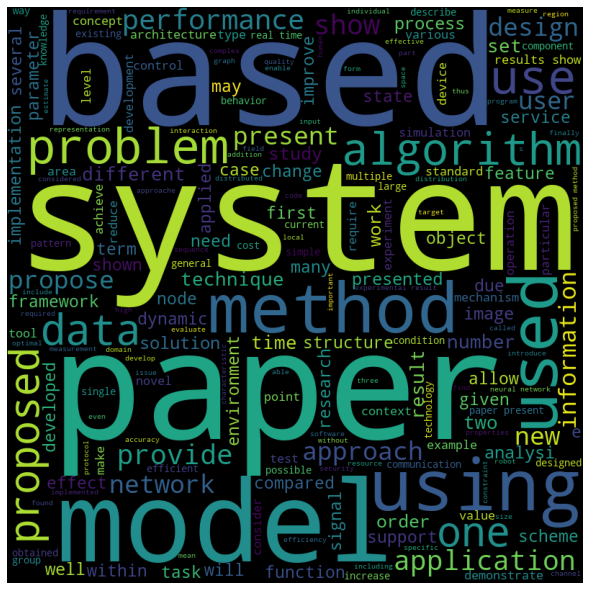

In [74]:
wordcloud = WordCloud(width = 800, height = 800,
                     background_color ='black',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()